# *Twitter Sentiment*

- Dataset acquired from [kaggle](https://www.kaggle.com/kazanova/sentiment140)
- Task at hand is to predict if the tweet is positive or negative

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import warnings
warnings.filterwarnings("ignore")
from sklearn.externals import joblib
from wordcloud import WordCloud            #importing required libraries 
from itertools import chain
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline 

In [122]:
data=pd.read_csv("twitter.csv",encoding='latin-1' ) 

### Understanding the data at hand

In [123]:
data.head()

,class_label,id,date,flag,userid,tweet
0,0,2053454569,Sat Jun 06 04:36:48 PDT 2009,NO_QUERY,bobby_the_cat,is trying to revise but keeps getting distracted
1,0,2328823358,Thu Jun 25 10:01:52 PDT 2009,NO_QUERY,Crash_Enburn,Farrah Fawcett died this morning.
2,0,1968020432,Fri May 29 20:37:05 PDT 2009,NO_QUERY,lonimarie803,hmmphh.. that sneak peek was hardly a peek
3,0,1550960487,Sat Apr 18 07:45:10 PDT 2009,NO_QUERY,tweetertwatter9,mall today. broke though. arrggg.
4,0,2328220484,Thu Jun 25 09:18:56 PDT 2009,NO_QUERY,wilbossman,@C_S15 But are you in any way surprised OA did...


In [124]:
data["class_label"].value_counts()

0    32000
4    29830
Name: class_label, dtype: int64

- Dataset contains 32000 negative tweets and 29830 positive tweets
- 0 being negative and 4 being positive
- There are 6 features in total but we only need the "tweet" feature

In [125]:
data['class_label'] = data['class_label'].replace([4],1)

- Changing 4 to 1 to make it easy for modelling 

In [126]:
data["class_label"].value_counts()

0    32000
1    29830
Name: class_label, dtype: int64

In [127]:
data.isnull().sum()

class_label    0
id             0
date           0
flag           0
userid         0
tweet          0
dtype: int64

- Dataset contains no null values

In [128]:
at=data[data['tweet'].str.contains("@")]

In [129]:
print(len(data.tweet))
print(len(data.tweet.unique()))

61830
61621


- Dataset contains 209 duplicates
- Removing the duplicates

In [130]:
data.drop_duplicates(subset=['tweet', 'userid'],keep = False, inplace = True)

In [131]:
data["word_count"] = data['tweet'].apply(lambda x: len(str(x).split()))

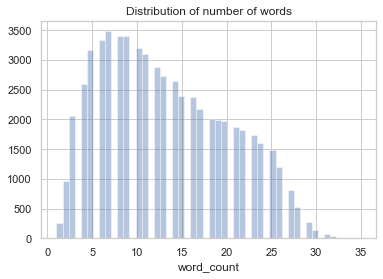

In [132]:
sns.set(style="whitegrid")
sns.distplot(data["word_count"],bins=50,kde=False)
plt.title("Distribution of number of words")
plt.show()

In [133]:
data.drop("word_count", axis=1, inplace=True)

- The  plot gives the distribution of length of words in a tweet
- There are more tweets around the length 6
- And the least are of length 30+

### Data cleaning

#### Remove usernames and URL's

In [134]:
for index,text in enumerate(data['tweet'][18:20]):
  print('tweet %d:\n'%(index+1),text)

tweet 1:
 @homestars You know, I'm really loving your service lately. It's one of the few really useful things in my life. Unlike my contractor 
tweet 2:
 http://twitpic.com/7vfsn - my own personal jesus. going to miss him 


In [135]:
def rem(i):
    j=" ".join(filter(lambda x:x[0]!='@', i.split())) #removing words starting with '@'
    j1=re.sub(r"http\S+", "", j)                       # removing urls
    j2=" ".join(filter(lambda x:x[0]!='&', j1.split()))  #the "&" was found to be used in many misspelled words and usernames
    return j2
       

In [136]:
data["tweet"]=data["tweet"].apply(rem) #applying the function

In [137]:
for index,text in enumerate(data['tweet'][18:20]):
  print('tweet %d:\n'%(index+1),text)

tweet 1:
 You know, I'm really loving your service lately. It's one of the few really useful things in my life. Unlike my contractor
tweet 2:
 - my own personal jesus. going to miss him


#### Converting common emoticons to their appropriate sentiment

In [138]:
def smiley(a):
    x1=a.replace(":‑)","happy")
    x2=x1.replace(";)","happy")
    x3=x2.replace(":-}","happy")
    x4=x3.replace(":)","happy")
    x5=x4.replace(":}","happy")
    x6=x5.replace("=]","happy")
    x7=x6.replace("=)","happy")
    x8=x7.replace(":D","happy")
    x9=x8.replace("xD","happy")
    x10=x9.replace("XD","happy")
    x11=x10.replace(":‑(","sad")    #using 'replace' to convert emoticons
    x12=x11.replace(":‑[","sad")
    x13=x12.replace(":(","sad")
    x14=x13.replace("=(","sad")
    x15=x14.replace("=/","sad")
    x16=x15.replace(":[","sad")
    x17=x16.replace(":{","sad")
  
    x18=x17.replace(":P","playful")
    x19=x18.replace("XP","playful")
    x20=x19.replace("xp","playful")
  
    
    x21=x20.replace("<3","love")
    x22=x21.replace(":o","shock")
    x23=x22.replace(":-/","sad")
    x24=x23.replace(":/","sad")
    x25=x24.replace(":|","sad")
    return x25

In [139]:
data['tweet']=data['tweet'].apply(smiley)

#### Converting all the tweets to lower case 

In [140]:
data['tweet']=data['tweet'].apply(lambda x: x.lower())

#### expanding contractions

In [141]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)   #using regular expressions to expand the contractions
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [142]:
data['tweet']=data['tweet'].apply(decontracted)

#### removing digits

In [143]:
data['tweet']=data['tweet'].apply(lambda x: re.sub('\w*\d\w*','', x))

#### remove punctuations

In [144]:
data['tweet']=data['tweet'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

#### Cleaning other oddities that were found

In [145]:
def odd(a):
    words = ['wi','ame','quot','ti','im']
    querywords = a.split()

    resultwords  = [word for word in querywords if word.lower() not in words]
    result = ' '.join(resultwords)
    return result

In [146]:
data["tweet"]=data["tweet"].apply(odd)

In [147]:
data["tweet"]=data["tweet"].apply(lambda x: re.sub(' +', ' ', x))

#### Removing stopwords

In [148]:
stop=["hey","oh","i", "me", "my", "myself", "we", "our","will", "go","got","ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about","between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such",  "nor", "only", "own", "same", "so", "than", "too", "s", "t", "just", "don", "should", "now","want","wanted","see","saw","new","still","gonna","going"]

In [149]:
print(stop)

['hey', 'oh', 'i', 'me', 'my', 'myself', 'we', 'our', 'will', 'go', 'got', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 's', 't', 'just', 'don', 'should', 'now', 'want', '

In [150]:
data["tweet"]=data['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#### Removing extra spaces 

In [151]:
data["tweet"]=data["tweet"].apply(lambda x: re.sub(' +', ' ', x))

### EDA

(-0.5, 999.5, 499.5, -0.5)

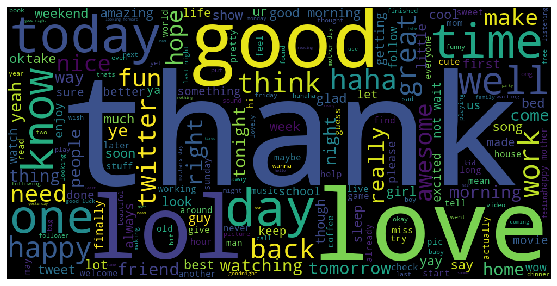

In [152]:
pos = data[data.class_label==1]
cloud= (' '.join(pos['tweet']))
wcloud = WordCloud(width = 1000, height = 500).generate(cloud)
plt.figure(figsize=(15,5))
plt.imshow(wcloud)
plt.axis('off')

- The above word cloud gives the words that are present in the positive tweets
- Bigger the word ,more times it appears in the positive tweets

(-0.5, 999.5, 499.5, -0.5)

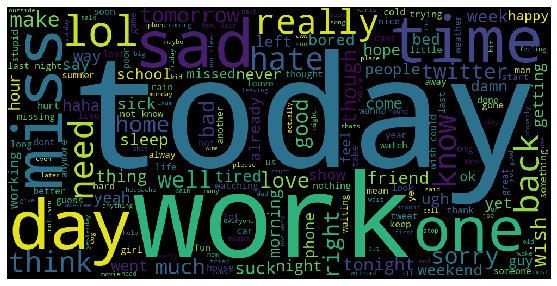

In [153]:
pos = data[data.class_label==0]
cloud= (' '.join(pos['tweet']))
wcloud = WordCloud(width = 1000, height = 500).generate(cloud)
plt.figure(figsize=(15,5))
plt.imshow(wcloud)
plt.axis('off')

In [154]:
data["word_count"] = data['tweet'].apply(lambda x: len(str(x).split()))

- The above word cloud gives the words that are present in the negative tweets
- Bigger the word ,more times it appears in the negative tweets

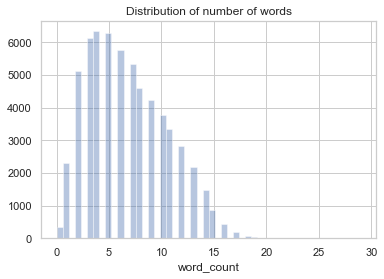

In [155]:
sns.set(style="whitegrid")
sns.distplot(data["word_count"],bins=50,kde=False)
plt.title("Distribution of number of words")
plt.show()

In [156]:
data.drop("word_count", axis=1, inplace=True)

- Plotting the distribution plot again after cleaning 
- Now, tweets containing around 3 words are more
- Tweets with words 15+ are the least 

### Model

In [157]:
X=data.drop(['class_label',"id","date","flag","userid"], axis = 1)  # seperating the class label
y=data["class_label"].values

In [158]:
X.head()

,tweet
0,trying revise keeps getting distracted
1,farrah fawcett died morning
2,hmmphh sneak peek hardly peek
3,mall today broke though arrggg
4,way surprised oa not launch today another job ...


In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Vectorization/Transformation

In [160]:
vectorizer = TfidfVectorizer() #Using TFIDF to vectorize the text

In [161]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,3)) 
vectorizer.fit(X_train['tweet'].values)           # Training the TFIDF model
x_tr=vectorizer.transform(X_train['tweet'].values)
x_te=vectorizer.transform(X_test['tweet'].values)

In [162]:
x_tr.shape   #We get 4191 features after vectorizing 

(43236, 4260)

#### Hyperparameter tuning

In [163]:
model = MultinomialNB()  
parameters = {'alpha':[0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5,
10, 50, 100]}
clf = GridSearchCV(model, parameters, cv=10,scoring='roc_auc',return_train_score=True)
clf.fit(x_tr, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.005,
                                   0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=0)

- Using Naive bayes as a base model for the Gridsearch .
- Gridsearch is performed to find the best hyperparameter i.e Alpha

In [164]:
results = pd.DataFrame.from_dict(clf.cv_results_)   # converting the results in to a dataframe
results = results.sort_values(['param_alpha'])           

In [165]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.013111,0.001046,0.004102,0.000537,1e-05,{'alpha': 1e-05},0.834867,0.836485,0.817728,0.819530,...,0.873820,0.873756,0.873397,0.873465,0.872999,0.872914,0.873609,0.873058,0.873152,0.000543
1,0.012512,0.000500,0.004002,0.000002,5e-05,{'alpha': 5e-05},0.834865,0.836522,0.817739,0.819576,...,0.873819,0.873755,0.873395,0.873464,0.872999,0.872912,0.873607,0.873056,0.873151,0.000543
2,0.012410,0.000799,0.003902,0.000540,0.0001,{'alpha': 0.0001},0.834863,0.836551,0.817743,0.819607,...,0.873817,0.873754,0.873393,0.873463,0.872998,0.872910,0.873606,0.873055,0.873150,0.000543
3,0.012410,0.000800,0.003702,0.000459,0.0005,{'alpha': 0.0005},0.834872,0.836673,0.817763,0.819714,...,0.873811,0.873748,0.873385,0.873459,0.872996,0.872903,0.873600,0.873048,0.873144,0.000542
4,0.012610,0.000490,0.003902,0.000300,0.001,{'alpha': 0.001},0.834873,0.836769,0.817788,0.819789,...,0.873804,0.873744,0.873377,0.873455,0.872994,0.872895,0.873595,0.873043,0.873139,0.000542


In [166]:
train_auc= results['mean_train_score'].values  #extracting the auc scores 
cv_auc = results['mean_test_score'].values

In [167]:
a1=[]
for i in parameters.values():
    a1.append(i)
alphas = list(chain.from_iterable(a1))

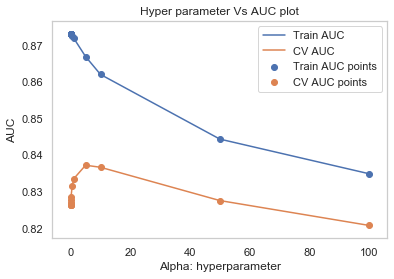

In [168]:
plt.plot(alphas, train_auc, label='Train AUC')
plt.plot(alphas, cv_auc, label='CV AUC')
plt.scatter(alphas, train_auc, label='Train AUC points')
plt.scatter(alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot")  
plt.grid()
plt.show()

- Plotting a graph between the hyperparameter and the AUC(Train,CV)
- From the graph , the best hyperparameter could be from 3 to 5 
- Lets confirm this by extracting the best alpha

In [169]:
bestparam=clf.best_params_['alpha']   #extracting the best hyperparameter

In [170]:
print("The best Alpha=",bestparam)

The best Alpha= 5


#### Final Model

In [171]:
mul_model = MultinomialNB(alpha=bestparam) #Building a Naive Bayes model with the best alpha
mul_model.fit(x_tr,y_train)               #Training the model

MultinomialNB(alpha=5, class_prior=None, fit_prior=True)

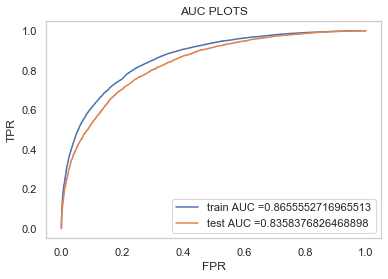

In [172]:
y_train_pred = mul_model.predict_proba(x_tr)[:,1]  #Prediction using the model(considering only log probability of each class)
y_test_pred = mul_model.predict_proba(x_te)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)   
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("AUC PLOTS")             #Plotting train and test AUC 
plt.grid()
plt.show()

In [173]:
trauc=round(auc(train_fpr, train_tpr),3)
teauc=round(auc(test_fpr, test_tpr),3)
print('Train AUC=',trauc)
print('Test AUC=',teauc)


Train AUC= 0.866
Test AUC= 0.836


- We have an auc score for both test and train >0.8
- This means our model has performed well
- And since the difference between train and test scores is very little , the model is not overfitting
- Ltt's build a confusion matrix to understand the performance better 

In [174]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]      #finding the best threashold 
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:                                 #building a confusion matrix with the best threashold 
            predictions.append(0)
    return predictions

In [175]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
TRCM=confusion_matrix(y_train, predict_with_best_t(y_train_pred, best_t))
TECM=confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))

the maximum value of tpr*(1-fpr) 0.6135631199057329 for threshold 0.48


In [176]:
def CM(x,y):
    labels = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in x.flatten()]
                    
    labels = [f"{v1}\n{v2}" for v1, v2 in
    zip(labels,group_counts)]
    labels = np.asarray(labels).reshape(2,2)       #Building a design for the confusion matrix
    sns.heatmap(x, annot=labels, fmt='', cmap='BuPu')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(y)
    plt.plot()

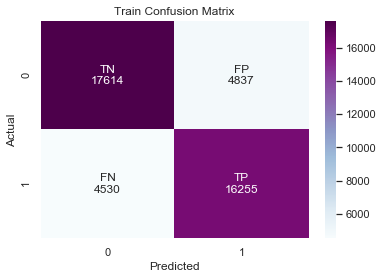

In [177]:
CM(TRCM,'Train Confusion Matrix')

- We have more true positives and true negatives
- which means more points were classified correctly
- The same can be observed in the test confusion matrix

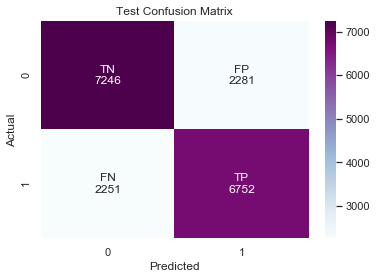

In [178]:
CM(TECM,'Test Confusion Matrix')

### Conclusion

- By using the naive bayes model we were able to get an AUC score >0.8
- Building a confusion matrix gave a better understanding of the performance 
- There were more True positives and True negatives which means more points were classified properly 
- Hence, our model worked fairly well and is ready for deployment 

In [179]:
#joblib.dump(mul_model, 'model.pkl')   #Storing the model for deployment 

In [180]:
#joblib.dump(vectorizer, 'vectorizer.pkl')